In [6]:
import numpy as np
import time
from keras.datasets import mnist

def preprocess_data(X, y, subset_size):
    X = X.astype('float32') / 255
    X = X.reshape((len(X), -1))
    X_subset = X[:subset_size]
    y_subset = y[:subset_size]
    num_classes = 10
    y_subset_encoded = np.zeros((y_subset.size, num_classes))
    y_subset_encoded[np.arange(y_subset.size), y_subset] = 1
    return X_subset, y_subset_encoded

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y, y_pred):
    m = y.shape[0]
    log_probs = -np.log(y_pred[np.arange(m), y.argmax(axis=1)] + 1e-8)
    return np.sum(log_probs) / m

class NeuralNetwork:
    def __init__(self, input_size, num_classes):
        self.input_size = input_size
        self.num_classes = num_classes
        self.weights = np.random.randn(input_size, num_classes) * 0.01
        self.loss_history = []  # Initialize an empty list to store loss values

    def forward(self, X):
        return softmax(np.dot(X, self.weights))

    def backward(self, X, y, y_pred, learning_rate):
        m = X.shape[0]
        gradient = np.dot(X.T, (y_pred - y)) / m
        self.weights -= learning_rate * gradient

    def train(self, X, y, learning_rate=0.01, num_epochs=1000):
        start_time = time.time()
        for epoch in range(num_epochs):
            y_pred = self.forward(X)
            loss = cross_entropy_loss(y, y_pred)
            self.backward(X, y, y_pred, learning_rate)
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss}')
            self.loss_history.append(loss)  # Save loss for each iteration
        end_time = time.time()
        total_run_time = end_time - start_time
        print("Total Run Time:", total_run_time, "seconds")


# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Process data
X_train_subset, y_train_subset = preprocess_data(X_train, y_train, subset_size=10000)

# Train model
model = NeuralNetwork(784, 10)  # 784 inputs (28x28 pixels), 10 outputs (digits 0-9)
model.train(X_train_subset, y_train_subset, learning_rate=0.01, num_epochs=1000)


Epoch 0, Loss: 2.300376796614066
Epoch 100, Loss: 1.5389772379888749
Epoch 200, Loss: 1.1774218383571984
Epoch 300, Loss: 0.9830078967867466
Epoch 400, Loss: 0.8636720686011331
Epoch 500, Loss: 0.7829140221494366
Epoch 600, Loss: 0.7243706396301786
Epoch 700, Loss: 0.6797690131475858
Epoch 800, Loss: 0.6445040528204578
Epoch 900, Loss: 0.6158120395897393
Total Run Time: 104.70666003227234 seconds


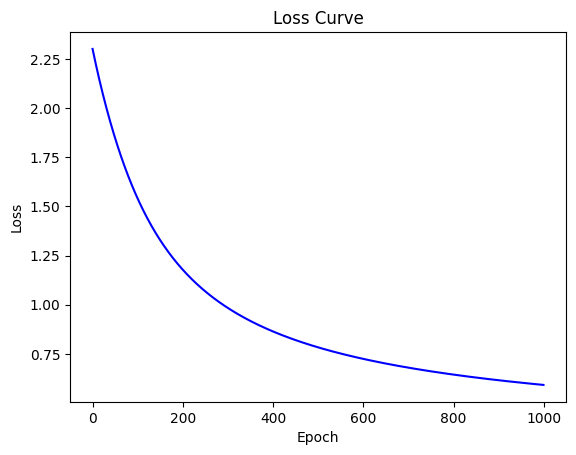

In [7]:
import matplotlib.pyplot as plt

# Assuming you have a list or array containing the loss values for each epoch
loss_values = model.loss_history

# Plotting the loss values
plt.plot(range(len(loss_values)), loss_values, color='blue')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [24]:
import numpy as np

def line_search2(f, gradient, x, alpha=0.9, beta=0.5, c=1e-2):
    f_x = f(x)
    while f(x - alpha * gradient) > f_x + c * alpha * np.dot(-gradient, gradient):
        alpha *= beta
        if alpha < 1e-4:
            break
    return alpha



In [20]:
def gdsa_linesearch2(f, grad_f, init_theta, alpha, beta, T0, max_iter, epsilon, delta_threshold, callback=None):
    """
    Gradient Descent Simulated Annealing (GDSA) algorithm with momentum.
    Uses gradient descent initially and switches to simulated annealing when improvements slow down.
    """
    theta = init_theta
    theta_updates = [theta.copy()]
    T = T0  # Initial temperature
    previous_loss = f(theta)  # Initialize previous loss
    no_improvement_count = 0

    for i in range(max_iter):
        gradient = grad_f(theta)
        alpha = line_search2(f, gradient, theta)
        theta_next = theta - alpha * gradient
        theta_change = np.linalg.norm(theta_next - theta)

        current_loss = f(theta_next)
        delta_E = current_loss - previous_loss

        if abs(delta_E) > delta_threshold:
            theta = theta_next
            previous_loss = current_loss
        else:
            P_accept = np.exp(-abs(delta_E) / T)
            rand = np.random.rand()
            if rand < P_accept:
                theta += np.sign(np.random.rand(*theta.shape) - 0.5) * alpha * gradient

            T = max(T * 0.99, 0.001)  # Only cool down if using SA
        theta_updates.append(theta.copy())
        no_improvement_count += 1

        if callback is not None:
            callback(i, theta)

        # Check for convergence
        if theta_change < epsilon and no_improvement_count > 20:
            break

    return theta, theta_updates


Running time: 254.0965552330017
Final loss: 0.43946774045366693


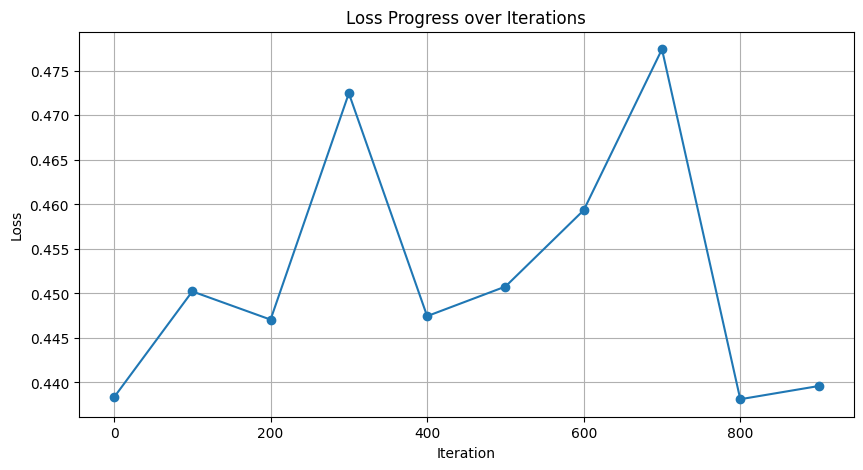

In [23]:
class NeuralNetwork:
    def __init__(self, input_size, num_classes):
        self.input_size = input_size
        self.num_classes = num_classes
        self.weights = np.random.randn(input_size, num_classes) * 0.01

    def forward(self, X):
        return softmax(np.dot(X, self.weights))

    def train(self, X, y, alpha, beta, T0, max_iter, epsilon=1e-4, delta_threshold=0.01):
        def loss_func(weights):
            self.weights = weights.reshape(self.input_size, self.num_classes)
            return self.f(X, y)

        def grad_func(weights):
            self.weights = weights.reshape(self.input_size, self.num_classes)
            return self.grad_f(X, y).flatten()

        init_theta = self.weights.flatten()
        loss_history = []
        final_theta, theta_updates = gdsa_linesearch2(loss_func, grad_func, init_theta, alpha, beta, T0, max_iter, epsilon, delta_threshold, lambda k, x: loss_history.append((k, loss_func(x))) if k % 100 == 0 else None)
        self.weights = final_theta.reshape(self.input_size, self.num_classes)

        return loss_history

    def f(self, X, y):
        y_pred = self.forward(X)
        return cross_entropy_loss(y, y_pred)

    def grad_f(self, X, y):
        y_pred = self.forward(X)
        m = X.shape[0]
        return np.dot(X.T, (y_pred - y)) / m

start_time = time.time()
loss_history = model.train(X_train_subset, y_train_subset, alpha=0.1, beta=0.9, T0=10, max_iter=1000)
end_time = time.time()

running_time = end_time - start_time
final_loss = model.f(X_train_subset, y_train_subset)
print("Running time:", running_time)
print("Final loss:", final_loss)

import matplotlib.pyplot as plt

iterations, losses = zip(*loss_history)
plt.figure(figsize=(10, 5))
plt.plot(iterations, losses, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Progress over Iterations')
plt.grid(True)
plt.show()


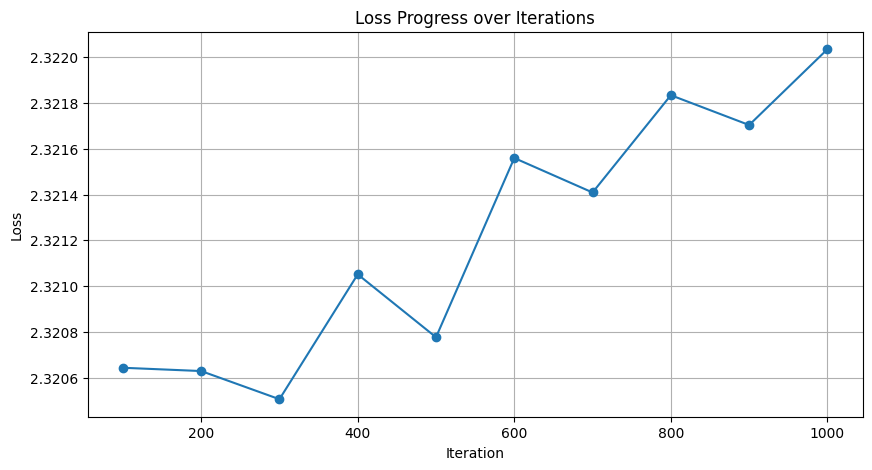

Running time: 27.029934644699097
Final loss: 2.322034967861423


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import time

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y, y_pred):
    m = y.shape[0]
    log_probs = -np.log(y_pred[np.arange(m), y.argmax(axis=1)] + 1e-8)
    return np.sum(log_probs) / m

class NeuralNetwork:
    def __init__(self, input_size, num_classes):
        self.input_size = input_size
        self.num_classes = num_classes
        self.weights = np.random.randn(input_size, num_classes) * 0.01
        self.loss_history = []  # Initialize an empty list to store loss values

    def forward(self, X):
        return softmax(np.dot(X, self.weights))

    def train(self, X, y, T0, max_iter, epsilon=1e-4):
        current_weights = self.weights.flatten()
        current_loss = self.f(X, y)
        T = T0
        for i in range(max_iter):
            # Randomly perturb weights
            perturbation = np.random.randn(*current_weights.shape) * epsilon
            proposed_weights = current_weights + perturbation
            self.weights = proposed_weights.reshape(self.input_size, self.num_classes)
            proposed_loss = self.f(X, y)

            # Simulated annealing acceptance criterion
            delta_E = proposed_loss - current_loss
            if delta_E < 0 or np.random.rand() < np.exp(-delta_E / T):
                current_weights = proposed_weights
                current_loss = proposed_loss
            else:
                self.weights = current_weights.reshape(self.input_size, self.num_classes)

            T = max(T * 0.95, 0.001)  # Cool down the temperature

            if (i + 1) % 100 == 0:
                self.loss_history.append(current_loss)  # Record loss every 100 iterations

            if np.linalg.norm(perturbation) < epsilon:
                break

        # Plotting the loss curve after training
        plt.figure(figsize=(10, 5))
        plt.plot(range(100, max_iter + 1, 100), self.loss_history, marker='o')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Loss Progress over Iterations')
        plt.grid(True)
        plt.show()

    def f(self, X, y):
        y_pred = self.forward(X)
        return cross_entropy_loss(y, y_pred)

# Assume X_train_subset, y_train_subset are defined and preprocessed
model = NeuralNetwork(784, 10)
start_time = time.time()
model.train(X_train_subset, y_train_subset, T0=10, max_iter=1000)
end_time = time.time()

running_time = end_time - start_time
final_loss = model.f(X_train_subset, y_train_subset)
print("Running time:", running_time)
print("Final loss:", final_loss)
